In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

In [4]:
df = pd.read_csv('data/189_clean_data_v2.csv')

### Random split model ###

Data pre-processing

In [5]:
# -----------------------
# Handling Missing Values
# -----------------------

# Since we used an inner join, missing values should be minimal, but verify
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# If any missing values exist, decide on a strategy. Here, we'll drop them.
df_clean = df.dropna()

print("\nAfter Handling Missing Values:")
print(df_clean.isnull().sum())

# -----------------------
# Convert date and exclude pre ETS phase 3 data
# -----------------------

# Convert 'date' column to datetime (if not already)
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Filter data for date >= '2013-01-01'
df = df[df['date'] >= '2013-01-01'].copy()

# Sort by date in ascending order
df = df.sort_values('date')

# Compute log returns for selected columns
for col in ['eu_ets', 'brent_crude', 'euronext100', 'ngh', 'rot_coal']:
    df[col] = np.log(df[col]) - np.log(df[col].shift(1))

# Drop any NaNs from shifting
df = df.dropna()

print("\nAfter Log Return Transform:")
print(df.head())


Missing Values in Each Column:
date             0
eu_ets           0
brent_crude     33
euronext100     32
ngh            126
rot_coal       389
dtype: int64

After Handling Missing Values:
date           0
eu_ets         0
brent_crude    0
euronext100    0
ngh            0
rot_coal       0
dtype: int64

After Log Return Transform:
           date    eu_ets  brent_crude  euronext100       ngh  rot_coal
1979 2013-01-03 -0.026922     0.000442    -0.001912 -0.012676 -0.002232
1980 2013-01-04 -0.009677    -0.003989     0.002932  0.027315 -0.002237
1981 2013-01-07  0.050564    -0.000800    -0.005583 -0.006683 -0.009564
1982 2013-01-08 -0.029713     0.004789    -0.002181 -0.014428 -0.009086
1983 2013-01-09 -0.040491     0.000354     0.002672 -0.032367  0.001140


Model spec and execution


Features Head:
      brent_crude  euronext100       ngh  rot_coal
1979     0.000442    -0.001912 -0.012676 -0.002232
1980    -0.003989     0.002932  0.027315 -0.002237
1981    -0.000800    -0.005583 -0.006683 -0.009564
1982     0.004789    -0.002181 -0.014428 -0.009086
1983     0.000354     0.002672 -0.032367  0.001140

Target Head (Log Return of eu_ets):
1979   -0.026922
1980   -0.009677
1981    0.050564
1982   -0.029713
1983   -0.040491
Name: eu_ets, dtype: float64

Training set: 1907 rows
Test set:     956 rows

Starting Grid Search (TimeSeriesSplit) for Hyperparameter Tuning...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Time-based Test Results:
Mean Squared Error (MSE): 0.0007
Root Mean Squared Error (RMSE): 0.0263
R-squared (R2 ): 0.0117


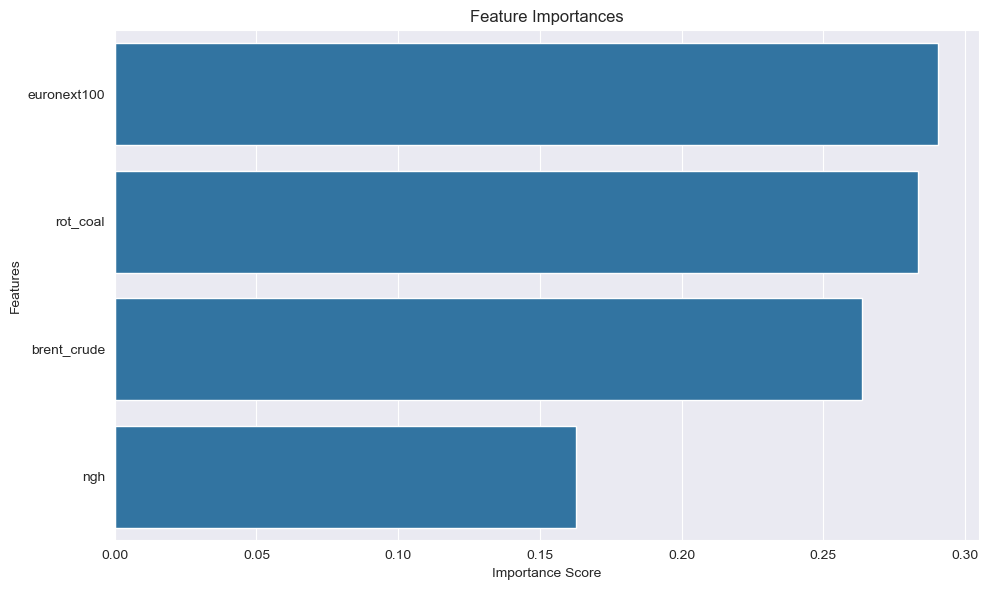

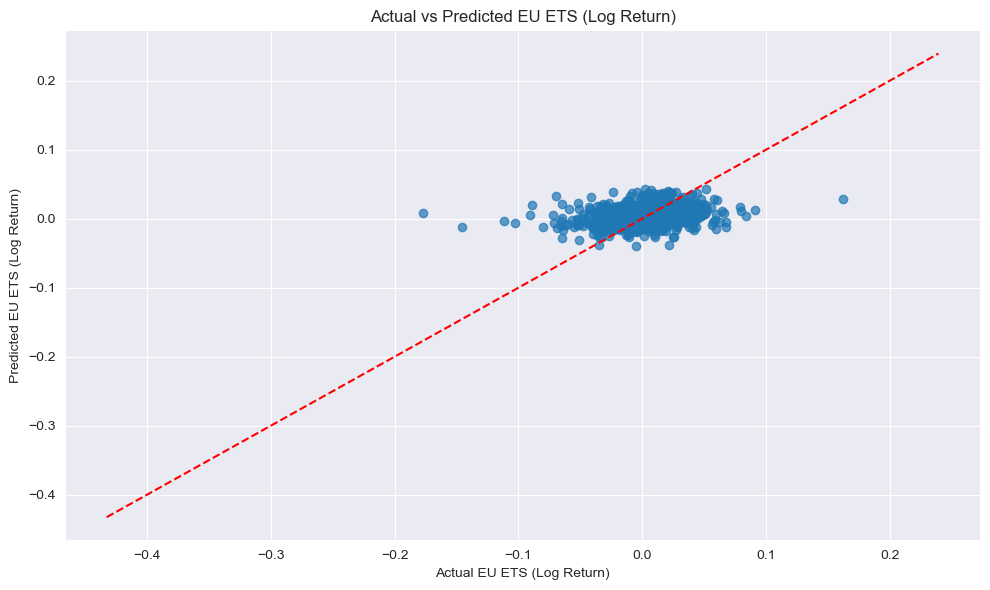


Model saved as 'random_forest_eu_ets_model.pkl'


In [6]:
# -----------------------------------------
# Define Features and Target
# -----------------------------------------

feature_columns = [
    c for c in df.columns
    if c not in ('date', 'eu_ets')  # Exclude date and target from features
]

target_column = 'eu_ets'

X = df[feature_columns]
y = df[target_column]

print("\nFeatures Head:")
print(X.head())

print("\nTarget Head (Log Return of eu_ets):")
print(y.head())

# Choose a cutoff date for final out-of-sample test
cutoff_date = '2021-01-01'

# Split into train (before cutoff) and test (on/after cutoff)
train_df = df[df['date'] < cutoff_date].copy()
test_df  = df[df['date'] >= cutoff_date].copy()

X_train = train_df[feature_columns]
y_train = train_df[target_column]

X_test  = test_df[feature_columns]
y_test  = test_df[target_column]

print(f"\nTraining set: {X_train.shape[0]} rows")
print(f"Test set:     {X_test.shape[0]} rows")


# Initialize TimeSeriesSplit
# n_splits is how many "folds" you want
tscv = TimeSeriesSplit(n_splits=5)

# Initialize RandomForest
rf = RandomForestRegressor(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,                         # Use TimeSeriesSplit instead of a fixed integer
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

print("\nStarting Grid Search (TimeSeriesSplit) for Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Best estimator
best_rf = grid_search.best_estimator_

# Make final predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nTime-based Test Results:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 ): {r2:.4f}")

# -------------------------------------------------
# Plot Feature Importances, Predictions
# -------------------------------------------------
importances = best_rf.feature_importances_
feature_importances = pd.Series(importances, index=feature_columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual EU ETS (Log Return)')
plt.ylabel('Predicted EU ETS (Log Return)')
plt.title('Actual vs Predicted EU ETS (Log Return)')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.tight_layout()
plt.show()

# Save the model
joblib.dump(best_rf, 'model_output/random_forest_eu_ets_daily_model.pkl')
print("\nModel saved as 'random_forest_eu_ets_model.pkl'")

Correlation matrix

In [10]:
# Calculate correlation matrix (by default, .corr() uses Pearson's correlation)
corr_matrix = df[feature_columns].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
               eu_ets  brent_crude  euronext100       ngh  rot_coal
eu_ets       1.000000     0.147387     0.197346  0.039327  0.112675
brent_crude  0.147387     1.000000     0.273383  0.063550  0.139539
euronext100  0.197346     0.273383     1.000000  0.054406  0.015285
ngh          0.039327     0.063550     0.054406  1.000000  0.084676
rot_coal     0.112675     0.139539     0.015285  0.084676  1.000000


Correlation matrix heatmap

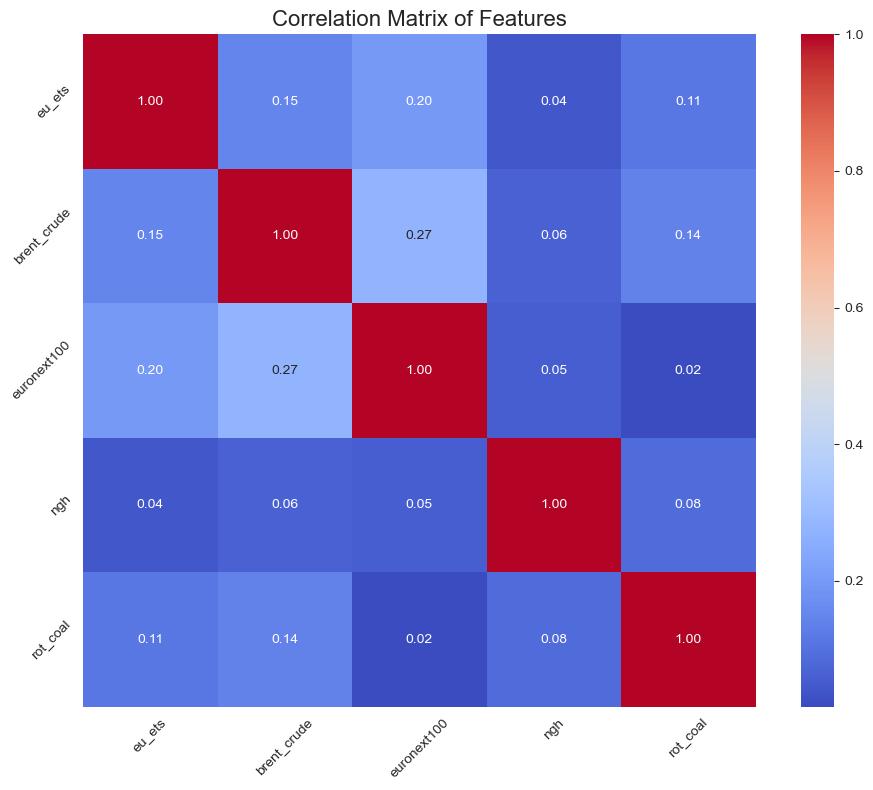

In [11]:
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(corr_matrix,
            annot=True,      # Display the correlation values in each cell
            cmap='coolwarm', # Color map style
            fmt=".2f",       # Format to display correlation values (2 decimal places)
            square=True      # Makes each cell square-shaped
           )

plt.title('Correlation Matrix of Features', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.yticks(rotation=45)
plt.tight_layout()       # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()